# Predicting Titanic Survival – Random Forest Approach

Predicting passenger survival on the Titanic using Random Forest. We start with baseline features, measure accuracy, then perform feature engineering (Titles, FamilySize, HasCabin) to improve performance.

## Analysis and Predictions

### Load Libraries and Data
Import the necessary Python libraries and load the Titanic dataset. Pandas is used for data manipulation, and scikit-learn provides modeling tools.

In [1]:
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [3]:
# Check where the kaggle files are
os.listdir("/kaggle/input/")

['titanic']

In [4]:
# Read the file
df = pd.read_csv("/kaggle/input/titanic/train.csv")

# Replace infinite values with NaN to avoid plotting warnings
df.replace([np.inf, -np.inf], np.nan, inplace=True)

### Show unmodified data, data types and general info

In [5]:
# See what the unmodified table looks like
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Exploratory Data Analysis
Visualize missing values, distributions, and survival relationships before cleaning or feature engineering.

In [6]:
# Check missing values
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


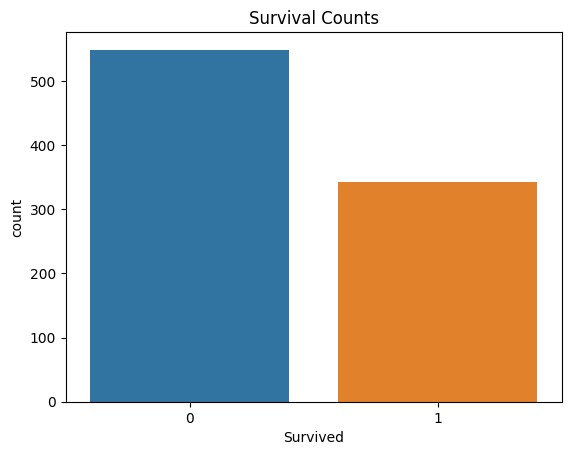

In [7]:
# Survival count plot
sns.countplot(x='Survived', data=df)
plt.title("Survival Counts")
plt.show()

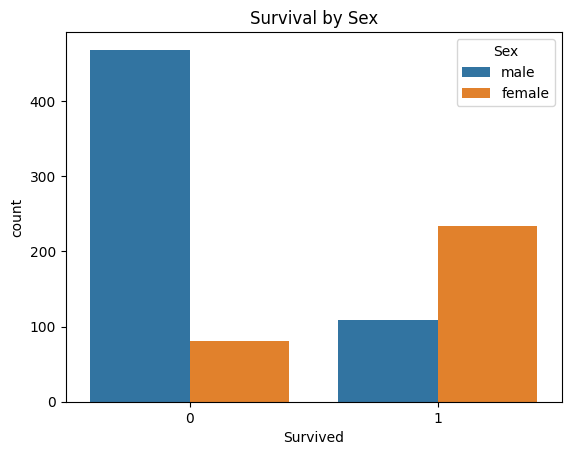

In [8]:
# Survival by Sex
sns.countplot(x='Survived', hue='Sex', data=df)
plt.title("Survival by Sex")
plt.show()

Observation: 

The plot shows a clear difference in survival rates between male and female passengers. Females had a significantly higher chance of survival compared to males, reflecting the "women and children first" evacuation policy on the Titanic. This indicates that Sex is an important predictor for survival.

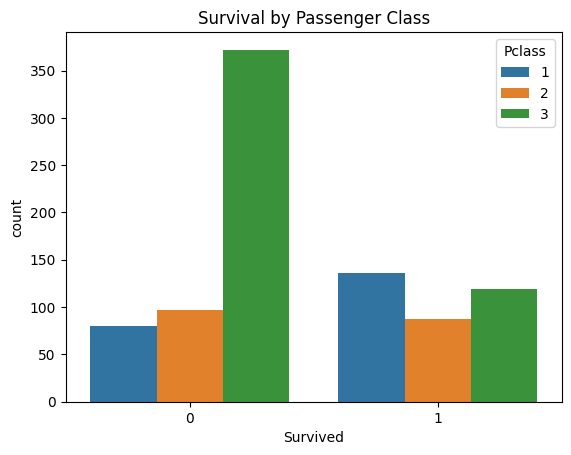

In [9]:
# Survival by Pclass
sns.countplot(x='Survived', hue='Pclass', data=df)
plt.title("Survival by Passenger Class")
plt.show()

Observation: 

Passengers in higher classes (1st class) had a higher survival rate, while those in 3rd class were less likely to survive. This reflects differences in cabin locations, access to lifeboats, and socio-economic status. Pclass is therefore a meaningful feature for predicting survival.

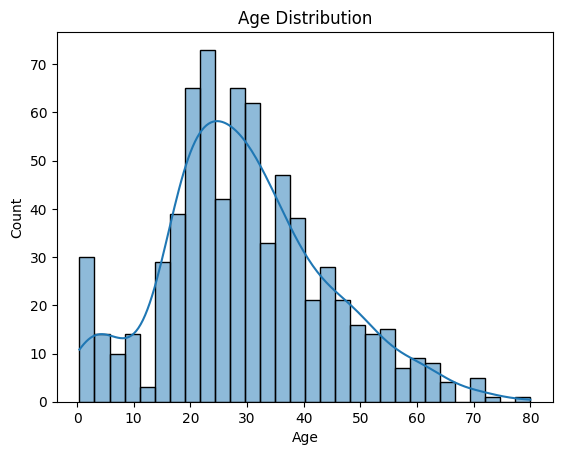

In [10]:
# Age distribution
sns.histplot(df['Age'], bins=30, kde=True)
plt.title("Age Distribution")
plt.show()

Observation:


The Age distribution shows a slight skew toward passengers aged 20–30, with fewer children and elderly passengers.

Why median was used:


We filled missing Age values with the median instead of the mean because the median is less sensitive to outliers. The Titanic Age distribution is slightly skewed, so the median better represents a “typical” passenger age than the mean.

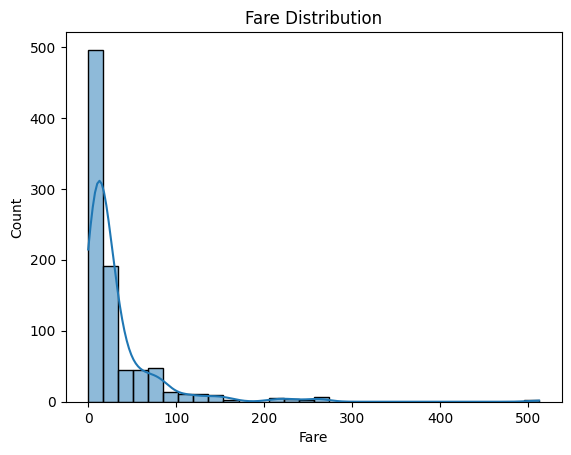

In [11]:
# Fare distribution
sns.histplot(df['Fare'], bins=30, kde=True)
plt.title("Fare Distribution")
plt.show()

Observation:


The Fare distribution shows a large peak at zero, corresponding to passengers who traveled for free or on very cheap tickets, and then rapidly decreases. Most passengers paid relatively low fares, while a small number paid very high fares, creating a right-skewed distribution.

Why median was used:


Because the Fare distribution is heavily skewed with extreme high values, we filled missing Fare values with the median to avoid being affected by these outliers. The median provides a more robust measure of a “typical” fare.

### Handle Missing Values
Check for missing values and fill them appropriately.

In [12]:
# Fill Age with median
df['Age'] = df['Age'].fillna(df['Age'].median())

# Fill Embarked with mode
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# Fill Fare with median (in case of test data)
df['Fare'] = df['Fare'].fillna(df['Fare'].median())

# Drop Cabin (we’ll make HasCabin later)
# df['Cabin'] = df['Cabin']  # handled in feature engineering

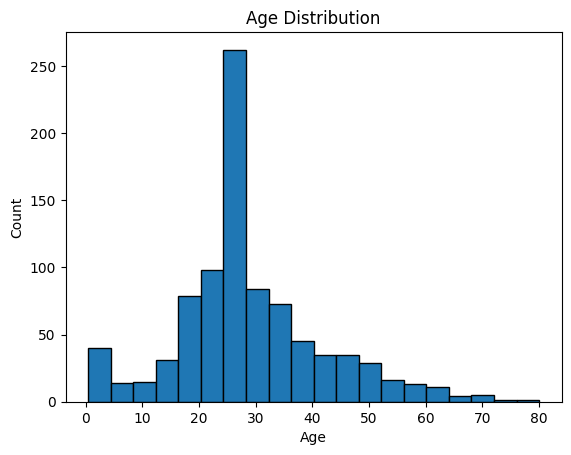

In [13]:
# Assuming df is your DataFrame
plt.hist(df['Age'].dropna(), bins=20, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')
plt.show()

### Prepare Features BEFORE Feature Engineering
Create a baseline feature set using basic features only.

In [14]:
X_base = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

# Encode Sex and Embarked for baseline
X_base = pd.get_dummies(X_base, columns=['Sex','Embarked'], drop_first=True)

y = df['Survived']

# Single train/test split
X_train_base, X_test_base, y_train, y_test = train_test_split(
    X_base, y, test_size=0.2, random_state=42
)

### Random Forest BEFORE Feature Engineering
Train a Random Forest classifier on the baseline features and evaluate accuracy.

In [15]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_base, y_train)
preds_base = rf.predict(X_test_base)
print("Random Forest Accuracy BEFORE feature engineering:", accuracy_score(y_test, preds_base))

Random Forest Accuracy BEFORE feature engineering: 0.8212290502793296


### Feature Engineering
Enhance the dataset with additional meaningful features:

1. FamilySize = SibSp + Parch
2. IsAlone = 1 if no family aboard
3. HasCabin = 1 if cabin information exists
4. Title = honorific extracted from passenger name (Mr, Mrs, Miss, Master, Rare)

Then, perform one-hot encoding for categorical features. Feature engineering helps the model capture more nuanced patterns

In [16]:
# Family size and alone
df['FamilySize'] = df['SibSp'] + df['Parch']
df['IsAlone'] = (df['FamilySize'] == 0).astype(int)

# HasCabin
df['HasCabin'] = df['Cabin'].notnull().astype(int)
df = df.drop('Cabin', axis=1)

# Extract Title
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace(['Mlle','Ms'],'Miss').replace('Mme','Mrs')
rare_titles = df['Title'].value_counts()[df['Title'].value_counts() < 10].index
df['Title'] = df['Title'].replace(rare_titles, 'Rare')

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['Sex','Embarked','Title'], drop_first=True)

### Prepare Features AFTER Feature Engineering
Build the new feature matrix with engineered features and align it with the previous train/test split.

In [17]:
X_fe = df.drop(['Survived','Name','Ticket'], axis=1)

# Align train/test splits with same indices
X_train_fe = X_fe.loc[X_train_base.index]
X_test_fe = X_fe.loc[X_test_base.index]

### Random Forest AFTER Feature Engineering
Train the same Random Forest classifier on the improved feature set and evaluate accuracy.

In [18]:
rf.fit(X_train_fe, y_train)
preds_fe = rf.predict(X_test_fe)
print("Random Forest Accuracy AFTER feature engineering:", accuracy_score(y_test, preds_fe))

Random Forest Accuracy AFTER feature engineering: 0.8547486033519553


## Doing the same on train.csv and save it as submission.csv

In [19]:
# --- Prepare test data for submission ---
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill missing values using train statistics
test_df['Age'] = test_df['Age'].fillna(df['Age'].median())
test_df['Fare'] = test_df['Fare'].fillna(df['Fare'].median())

# Feature engineering (same as training)
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch']
test_df['IsAlone'] = (test_df['FamilySize'] == 0).astype(int)
test_df['HasCabin'] = test_df['Cabin'].notnull().astype(int)
test_df['Title'] = test_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_df['Title'] = test_df['Title'].replace(['Mlle','Ms'],'Miss').replace('Mme','Mrs')
rare_titles_test = test_df['Title'].value_counts()[test_df['Title'].value_counts() < 10].index
test_df['Title'] = test_df['Title'].replace(rare_titles_test, 'Rare')

# Drop unused columns
test_df = test_df.drop(['Cabin','Name','Ticket'], axis=1)

# One-hot encode categorical features
test_df = pd.get_dummies(test_df, columns=['Sex','Embarked','Title'], drop_first=True)

# Align columns with training features
X_submit = test_df.reindex(columns=X_fe.columns, fill_value=0)

# Predict using previously trained rf
preds_submit = rf.predict(X_submit)

# Create submission file
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': preds_submit
})

submission.to_csv("submission.csv", index=False)
print("Submission saved as submission.csv")

Submission saved as submission.csv
